# Imports

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import minimize

## Convert data files to csv

### Decathlon

In [49]:
# Load RData file
rdata = pyreadr.read_r("data/decathlon.RData")
rdata

OrderedDict([('X',
                            100m  Long.jump  Shot.put  High.jump   400m  110m.hurdle  \
              rownames                                                                 
              SEBRLE       11.04       7.58     14.83       2.07  49.81        14.69   
              CLAY         10.76       7.40     14.26       1.86  49.37        14.05   
              KARPOV       11.02       7.30     14.77       2.04  48.37        14.09   
              BERNARD      11.02       7.23     14.25       1.92  48.93        14.99   
              YURKOV       11.34       7.09     15.19       2.10  50.42        15.31   
              WARNERS      11.11       7.60     14.31       1.98  48.68        14.23   
              ZSIVOCZKY    11.13       7.30     13.48       2.01  48.62        14.17   
              McMULLEN     10.83       7.31     13.76       2.13  49.91        14.38   
              MARTINEAU    11.64       6.81     14.57       1.95  50.14        14.93   
             

In [50]:
# Access the data frame from the loaded RData file
decathlon = rdata["X"]
decathlon.head()

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
rownames,,,,,,,,,,
SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7
CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5
KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2
BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1
YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4


In [51]:
# Convert the data frame to a CSV file
decathlon.to_csv("decathlon.csv", index=True)

### Train and test datafiles

In [52]:
train = {
    f"{letter}": pd.read_csv(
        f"data/train{letter}", delimiter=" ", names=["x1", "x2", "y"]
    )
    for letter in ["A", "B", "C"]
}
train["A"]

,x1,x2,y
0,12.138367,6.455699,1
1,10.622594,11.083096,0
2,11.777052,8.121582,1
3,10.960882,12.226554,0
4,11.296539,10.211002,0
...,...,...,...
95,10.188695,6.171622,1
96,11.024072,4.082187,1
97,11.090619,10.954867,0
98,9.840793,4.902898,1


In [53]:
test = {
    f"{letter}": pd.read_csv(
        f"data/test{letter}", delimiter=" ", names=["x1", "x2", "y"]
    )
    for letter in ["A", "B", "C"]
}
test["A"]

,x1,x2,y
0,12.356261,6.053231,1
1,11.842674,4.832690,1
2,12.080976,5.739803,1
3,9.435296,8.878012,0
4,11.023415,6.173500,1
...,...,...,...
95,12.132122,10.539799,0
96,10.948403,6.676466,1
97,8.728051,5.950333,1
98,9.376795,9.968496,0


# 1- Classification

## 1.1 Analyse linéaire discriminante

### a- Ecrire l'estimateur du maximum de vraisemblance des paramètres du modèle

$$\begin{align}

L_{(x_i, y_i)_i}(\pi, \mu_0, \mu_1, \Sigma) 
    & = log \hspace{8px} p(x_1,..., x_n, y_1,...y_n | \pi, \mu_0, \mu_1, \Sigma) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i, y_i | \pi, \mu_0, \mu_1, \Sigma) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i | y_i, \mu_0, \mu_1, \Sigma) * p(y_i | \pi) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i | y_i, \mu_0, \mu_1, \Sigma) + \sum_{i=1}^n log \hspace{8px} p(y_i | \pi)
\end{align}$$

On remarque qu'en dérivant par rapport à $\pi$ dans (4), on perdra la somme de gauche.  
De même, en dérivant par rapport à $\mu_0, \mu_1$ ou $\Sigma$, on perdra la somme de droite.  
On va donc calculer $\hat{\pi}_{EMV}$ et $\hat{\mu_0}_{EMV}$, $\hat{\mu_1}_{EMV}$, $\hat{\Sigma}_{EMV}$ à part.

**Commençons par calculer $\hat{\pi}_{EMV}$**   

$$\begin{align*}

L_{(y_i)_i}(\pi) & = log \hspace{8px} p(y_1,...y_n | \pi) \\
    & = \sum_{i=1}^n log \hspace{8px} p(y_i | \pi) \\
    & = \sum_{i=1}^n log \hspace{8px} \pi^{y_i} \cdot (1-\pi)^{1-y_i} \\
    & = \sum_{i=1}^n y_i \cdot log(\pi) + (1-y_i) \cdot log(1-\pi) \\ 

\end{align*}$$

Dérivons cette quantité par rapport à $\pi$

$$\begin{align*}

\nabla_\pi(L_{(y_i)_i}(\pi)) & = \sum_{i=1}^n \frac{y_i}{\pi} - \frac{1}{1-\pi} + \frac{y_i}{1-\pi} \\
    & = - \frac{n}{1-\pi} + \sum_{i=1}^n \frac{y_i}{\pi(1-\pi)}
    
\end{align*}$$

Maximiser la vraisemblance revient à maximiser la log-vraisemblance par croissance de la fonction logarithme sur $[0, 1]$, l'ensemble de définition de $\pi$.  
Déterminons la valeur de $\pi$ qui maximise la log-vraisemblance.  

Soit $\pi \in [0, 1] / \nabla_\pi(L_{(y_i)_i}(\pi)) = 0$,
alors on a
$$ \sum_{i=1}^n \frac{y_i}{\pi(1-\pi)} = \frac{n}{1-\pi} $$
i.e.
$$ \pi = \frac{1}{n} \sum_{i=1}^{n} y_i = \bar{y}$$

Donc $\boxed{\hat{\pi}_{EMV} = \bar{y}}$ 


**A présent, calculons $\hat{\mu_0}, \hat{\mu_1}$ et $\hat{\Sigma}$**

$$\begin{align*}

L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma)
    & = log \hspace{8px} p(x_1,...x_n | y_1,...,y_n, \mu_0, \mu_1, \Sigma) \\
    & = \sum_{i=1}^n log \hspace{8px} p(x_i | y_i, \mu_0, \mu_1, \Sigma) \\
    & = \begin{align*}
        \sum_{i=1}^n
            & \mathbb{1}_{y_i = 0} \cdot log \hspace{8px} \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot \exp^{-\frac{1}{2} (x_i - \mu_0)^T \Sigma^{-1} (x_i - \mu_0)} \\
            & \mathbb{1}_{y_i = 1} \cdot log \hspace{8px} \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot \exp^{-\frac{1}{2} (x_i - \mu_1)^T \Sigma^{-1} (x_i - \mu_1)} \\
        \end{align*}
        \\
    & = \begin{align*}
        \sum_{i=1}^n
            & \mathbb{1}_{y_i = 0} \cdot [ \frac{1}{2} \cdot log(2\pi^{2}|\Sigma|) - \frac{1}{2}
            \cdot (x_i - \mu_0)^T \Sigma^{-1} (x_i - \mu_0) ] \\
            & \mathbb{1}_{y_i = 1} \cdot [ \frac{1}{2} \cdot log(2\pi^{2}|\Sigma|) - \frac{1}{2}
            \cdot (x_i - \mu_1)^T \Sigma^{-1} (x_i - \mu_1) ]
        \end{align*}

\end{align*}$$

On peut calculer, à partir de cette forme, le gradient de la log vraisemblance par rapport à $\mu_0$.

$$
\nabla_{\mu_0}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma))
    = - \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot \Sigma^{-1} \cdot (x_i - \mu_0)
$$
Et alors, on peut maximiser la log vraisemblance.  
Soit $\mu_0 \in \mathbb{R}^2 / \nabla_{\mu_0}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma)) = 0_2$, on a alors
$$
- \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot ( \Sigma^{-1} \cdot x_i - \Sigma^{-1} \cdot \mu_0 ) = 0
$$
Introduisons les notations $n_0 = card\{i \in [1;n] / y_i = 0\}$, le nombre d'individus dans la classe 0,  
et $\bar{x_0} = \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot x_i$, la moyenne des individus de la classe 0.  

On a alors
$$ n_0 \cdot \Sigma^{-1} \mu_0 = \Sigma^{-1} \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot x_i
$$
Et donc
$$\boxed{\mu_0 = \hat{\mu_0} = \frac{\bar{x_0}}{n_0}}
$$


De la même façon, on calcule $\boxed{\displaystyle \hat{\mu_1} = \frac{\bar{x_1}}{n_1}}$

**Calcul de $\hat{\Sigma}$ :**  
On sait que $\displaystyle \hat{\Sigma_{EMV}} = \sum_{i=1}^{n} (x_i - \hat{\mu_{EMV}}) \cdot (x_i - \hat{\mu_{EMV}})^T$ pour un vecteur aléatoire gaussien.

Dans notre cas à deux classes,
$$\hat{\Sigma_{EMV}} = 
    \frac{
        \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} (x_i - \hat{\mu_0}) \cdot (x_i - \hat{\mu_0})^T
        + \sum_{i=1}^{n} \mathbb{1}_{y_i = 1} (x_i - \hat{\mu_1}) \cdot (x_i - \hat{\mu_1})^T
        }{
            n
        }
$$

**Justification :**  
En réutilisant la preuve du cours,  
$$
\begin{align*}
\nabla_{\Sigma}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma))
    =
    &- \frac{n_0}{2}\Sigma^{-1}
    + \frac{1}{2}\Sigma^{-1} \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} (x_i - \mu_0) \cdot (x_i - \mu_0)^T \cdot \Sigma^{-1} \\
    &-
    \frac{n_1}{2}\Sigma^{-1}
    + \frac{1}{2}\Sigma^{-1} \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T \cdot \Sigma^{-1}
\end{align*}
$$
On peut alors maximiser la vraisemblance :  

$\nabla_{\Sigma}(L_{(x_i)_i}(y_i, \mu_0, \mu_1, \Sigma)) = 0_{(2,2)}$

$$\Leftrightarrow
\begin{align*}
0   =
    &- \frac{n_0}{2}\Sigma + \frac{1}{2} \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} (x_i - \mu_0) \cdot (x_i - \mu_0)^T \\
    &-
    \frac{n_1}{2}\Sigma + \frac{1}{2} \sum_{i=1}^{n} \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T
\end{align*}
$$

$$\Leftrightarrow
0 = -\frac{n_0 + n_1}{2} \cdot \Sigma + \frac{1}{2}
    \cdot \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot (x_i - \mu_0) \cdot (x_i - \mu_0)^T
    + \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T
$$

$$\Leftrightarrow
\boxed{
\Sigma =
\frac{
        \sum_{i=1}^{n} \mathbb{1}_{y_i = 0} \cdot (x_i - \mu_0) \cdot (x_i - \mu_0)^T
        + \mathbb{1}_{y_i = 1} (x_i - \mu_1) \cdot (x_i - \mu_1)^T
    }{
        n_0 + n_1
    }
}
$$


### b- Donner la probabilité conditionnelle $P(Y=1|X=x)$. Comparer avec la même quantité dans le cadre de la régression logistique

On rappel que l'on note $p(x|\theta)$ la fonction de densité de la loi marginale de $X$ de paramètre $\theta$ évaluée en $x$.
$$\begin{align}
P(Y=1 | X=x)
    &= \frac{p(x | y=1, \theta) \cdot p(y=1|\pi)}{p(x | \theta)} \\
    &= \frac{\mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi}{p(x | \theta)} \\
\end{align}
$$
Par renversement du conditionnement avec la formule de Bayes.  

On peut calculer la loi marginale de $X$ au dénominateur :
$$
\begin{align*}
p(x | \theta)
    =& \mathcal{N}(x ; \mu_0, \Sigma) \cdot p(y=0|\pi) + \mathcal{N}(x ; \mu_1, \Sigma) \cdot p(y=1|\pi) \\
    =& \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot e^{-\frac{1}{2} (x - \mu_0)^T \Sigma^{-1} (x - \mu_0)} \cdot (1-\pi)
    + \frac{1}{\sqrt{2\pi^{2}|\Sigma|}} \cdot e^{-\frac{1}{2} (x - \mu_1)^T \Sigma^{-1} (x - \mu_1)} \cdot \pi
\end{align*}
$$
$X$ est un mélange de gaussiennes de même matrices de variances covariances et de moyennes différentes.

Développons la formule.

$$\begin{align*}
P(Y=1 | X=x)
    &= \frac{
        \mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi
    }{
        \mathcal{N}(x ; \mu_0, \Sigma) \cdot (1-\pi) + \mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi
    } \\
    &= \frac{1}{
        1 + \frac{
            \mathcal{N}(x ; \mu_0, \Sigma) \cdot (1-\pi)
        }{
            \mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi
        }
    } \hspace{10px} \text{en factorisant par $\mathcal{N}(x ; \mu_1, \Sigma) \cdot \pi$ et en supposant que $\pi \ne 0$} \\
    &= \frac{1}{
        1 + \frac{1-\pi}{\pi} \cdot
        \exp[\frac{1}{2}(
                    (x-\mu_0)^T \Sigma^{-1} (x-\mu_0)
                -
                    (x-\mu_1)^T \Sigma^{-1} (x-\mu_1)
                )]
    }
\end{align*}
$$

**Dans le cas $\pi = \frac{1}{2}$, on peut se ramener à la régression logistique :**

$$\begin{align*}
P(Y=1 | X=x)
    &= \frac{1}{
        1 + \exp[\frac{1}{2}(
                    (x-\mu_0)^T \Sigma^{-1} (x-\mu_0)
                -
                    (x-\mu_1)^T \Sigma^{-1} (x-\mu_1)
                )]
    } \\
    &= \frac{1}{
        1 + \exp(
                x^T \Sigma^{-1} \mu_1 - x^T \Sigma^{-1} \mu_0
                + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
        )} \\
    &= \frac{1}{
        1 + \exp(
                x^T \Sigma^{-1} (\mu_1 - \mu_0)
                + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
        )} \\
    &= \frac{1}{
        1 + \exp(
                x^T \beta
                + \beta_0
        )}
\end{align*}
$$
En notant $\beta = \Sigma^{-1} (\mu_1 - \mu_0)$ et $\beta_0 = \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1$  

Pour une valeur de $\pi \in [0 ; 1]$ quelconque, on remarque que l'on a un critère de classification plus riche que la régression logistique.  
En effet, l'analyse linéaire discriminante prend en compte les poids associés aux classes :

$$ P(Y=1 | X=x) = \frac{1}{1 + \frac{1 - \pi}{\pi} \exp(x^T \beta + \beta_0)} $$

### c- Implémenter l’EMV pour ce modèle
Appliquer l’EMV aux données. Représenter graphiquement les données sous la forme d’un nuage de points dans $\mathbb{R}^2$ ainsi que la fonction définie pour x∈R2 par l’équation $P(Y=1|X=x)=1/2$

#### Définitions de fonctions

In [54]:
def calc_pi_mle(dataset: pd.DataFrame) -> float:
    """Calculate maximum likelihood estimator for pi

    Args:
        dataset (pd.DataFrame): Dataset containing a binary class column named "y"

    Returns:
        float: Maximum likelihood for pi
    """

    y = dataset.loc[:, "y"]
    pi_mle = sum(y) / len(y)

    return pi_mle

In [55]:
def calc_mu_mle(dataset: pd.DataFrame) -> tuple:
    """Calculate maximum likelihood estimator for mu_0 and mu_1

    Args:
        dataset (pd.DataFrame): Two dimensional dataset ("x1", "x2") with a binary class column "y"

    Returns:
        tuple: (mu0_mle, mu1_mle)
    """

    # Split dataset based on class
    class0 = dataset[dataset["y"] == 0]
    class1 = dataset[dataset["y"] == 1]

    # Calculate mu0_mle and mu1_mle
    mu0_mle = class0.loc[:, ["x1", "x2"]].sum() / len(class0)
    mu1_mle = class1.loc[:, ["x1", "x2"]].sum() / len(class1)

    # Convert as numpy array
    mu0_mle = np.array(mu0_mle)
    mu1_mle = np.array(mu1_mle)

    return (mu0_mle, mu1_mle)

In [56]:
def calc_sigma_mle(dataset: pd.DataFrame, mu0_mle: float, mu1_mle: float) -> np.ndarray:
    """Calculate maximum likelihood for variance covariance matrix

    Args:
        dataset (pd.DataFrame): Two dimensional dataset ("x1", "x2") with a binary class column "y"
        mu0_mle (float): MLE for mu0
        mu1_mle (float): MLE for mu1

    Returns:
        np.ndarray: MLE for sigma of shape (2, 2)
    """
    # Split dataset based on class
    class0 = dataset[dataset["y"] == 0]
    class1 = dataset[dataset["y"] == 1]

    # Transform into numpy array for easier computation
    class0 = np.array(class0[["x1", "x2"]])
    class1 = np.array(class1[["x1", "x2"]])

    sum_over_class1 = (class0 - mu0_mle).T @ (
        class0 - mu0_mle
    )  # (2, 52) * (52, 2) = (2, 2)
    # (52, 2) - (2,) substract the (2,) vector
    # element wise to each row of the (52, 2) matrix in numpy
    sum_over_class2 = (class1 - mu1_mle).T @ (class1 - mu1_mle)

    sigma_mle = (sum_over_class1 + sum_over_class2) / len(
        dataset
    )  # len(dataset) = n_0 + n_1 = n

    return sigma_mle

#### Calculs des EMV

In [57]:
# Apply MLE to train data


dataset = train["B"]

pi_mle = calc_pi_mle(dataset)
mu0_mle, mu1_mle = calc_mu_mle(dataset)
sigma_mle = calc_sigma_mle(dataset, mu0_mle=mu0_mle, mu1_mle=mu1_mle)

#### Tracé du nuage de points et de la frontière de décision

**Cherchons l'équation de droite pour notre frontière de décision.**

$$ P(Y=1|X=x) = \frac{1}{2}
$$

$$\Leftrightarrow
\frac{1}{
        1 + \frac{1-\pi}{\pi} \cdot
        \exp[x^T \Sigma^{-1} (\mu_1 - \mu_0)
            + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1]
    } = \frac{1}{2}
$$

$$ \Leftrightarrow
\frac{1-\pi}{\pi} \cdot
\exp[x^T \Sigma^{-1} (\mu_1 - \mu_0)
    + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
    ]
= 1
$$

$$ \Leftrightarrow
\exp[x^T \Sigma^{-1} (\mu_1 - \mu_0)
    + \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
    ]
= \frac{\pi}{1-\pi} \hspace{8px} \text{en supposant que $\pi \ne 1$}
$$

$$ \Leftrightarrow
x^T \Sigma^{-1} (\mu_1 - \mu_0)
+ \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
= \ln(\frac{\pi}{1-\pi}) \hspace{8px} \text{car $\frac{\pi}{1-\pi} > 0$}
$$

$$ \Leftrightarrow
x^T \Sigma^{-1} (\mu_1 - \mu_0)
=   - \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0
    + \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
    + \ln(\frac{\pi}{1-\pi})
$$

Notons $x^T = (x_1, x_2)$ et $\mu_1 - \mu_0 = \lambda = (\lambda_1, \lambda_2)$  
Alors 
$$ x^T \Sigma^{-1} (\mu_1 - \mu_0)
    = x_1 \cdot (\Sigma^{-1}_{1,1} \lambda_1 + \Sigma^{-1}_{1,2} \lambda_2)
    + x_2 \cdot (\Sigma^{-1}_{2,1} \lambda_1 + \Sigma^{-1}_{2,2} \lambda_2)
$$

Avec cette forme développée, nous pouvons expliciter la formule de la droite d'équation
$P(Y=1|X=x) = \frac{1}{2}$

$$\Leftrightarrow

x_1 = \frac{
        - \frac{1}{2} \mu_0 \Sigma^{-1} \mu_0
        + \frac{1}{2} \mu_1 \Sigma^{-1} \mu_1
        + \ln(\frac{\pi}{1-\pi})
        - x_2 \cdot (\Sigma^{-1}_{2,1} \lambda_1 + \Sigma^{-1}_{2,2} \lambda_2)
}{
    \Sigma^{-1}_{1,1} \lambda_1 + \Sigma^{-1}_{1,2} \lambda_2
}
$$

On peut désormais calculer l'équation de la droite de séparation de façon explicite, sans avoir à faire de *meshgrid* sur notre espace de données.

In [58]:
# Calculate inverse of sigma_mle
sigma_mle_inv = np.linalg.inv(sigma_mle)

# Define lambda_ as above
lambda_ = mu1_mle - mu0_mle

In [59]:
# Make a sample vector for x2
xx2 = np.linspace(4, 14, 100)

# Calculate upper part of the fraction above
numerateur = (
    (-1 / 2) * (mu0_mle @ sigma_mle_inv @ mu0_mle.T)
    + (1 / 2) * (mu1_mle @ sigma_mle_inv @ mu1_mle.T)
    + np.log(pi_mle / (1 - pi_mle))
    - xx2 * (sigma_mle_inv[1, 0] * lambda_[0] + sigma_mle_inv[1, 1] * lambda_[1])
)

# Calculate lower part of the fraction above
denominateur = sigma_mle_inv[0, 0] * lambda_[0] + sigma_mle_inv[0, 1] * lambda_[1]

# Calculate f(xx2), the border of decision
f_xx2 = numerateur / denominateur

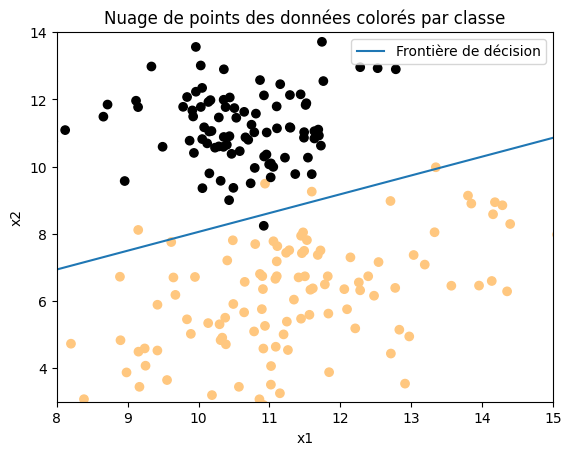

In [60]:
plt.scatter(
    dataset.loc[:, "x1"], dataset.loc[:, "x2"], c=dataset.loc[:, "y"], cmap="copper"
)
plt.plot(f_xx2, xx2, label="Frontière de décision")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Nuage de points des données colorés par classe")
plt.legend()
plt.ylim([3, 14])
plt.xlim([8, 15])
plt.show()

## 1.2 Régression logistique

On rappelle le modèle de régression logistique :

$$
y_i | x_i, \beta \sim \text{B}(g(x_i^\top \beta)), \quad \forall i \in \{1, \ldots, n\},
$$

où $ g : t \rightarrow \frac{1}{1 + \exp(-t)}, \hspace{8px} \forall t \in \mathbb{R} $ est la fonction logistique.  

La fonction d'erreur à optimiser (minimiser) est la fonction de vraisemblance négative :  

$$ -\mathcal{L}_{(x_i, y_i)_i} (\beta) = -\frac{1}{n} \sum_{i=1}^{n} \left\{ y_i \log g(x_i^\top \beta) + (1 - y_i) \log(1 - g(x_i^\top \beta)) \right\}
$$



### a- Donner les valeurs numériques des paramètres appris

In [61]:
# Define sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Define cost function for logistic regression
def log_reg_cost_function(params: np.ndarray, X: np.ndarray, y: np.ndarray):
    predictions = sigmoid(np.dot(X, params))
    error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    cost = (1 / len(y)) * sum(error)
    return cost

In [62]:
# Define X and y
X = dataset.loc[:, ["x1", "x2"]]
y = dataset.loc[:, "y"]

# Add bias to X
X = np.c_[np.ones((X.shape[0], 1)), X]

# Init parameters
beta = np.zeros(X.shape[1])

# Optimize cost function
beta_hat = minimize(fun=log_reg_cost_function, x0=beta, args=(X, y))

In [63]:
beta_hat = beta_hat.x

# Print parameters of the model
for i, param in enumerate(beta_hat):
    print(f"beta_{i} = {param}")

beta_0 = 13.430048728509414
beta_1 = 1.8424592405136777
beta_2 = -3.7139987979626263


### b- Représenter graphiquement les données sous la forme d’un nuage de points dans $\mathbb{R}^2$ ainsi que la fonction définie pour x∈R2 par l’équation $P(Y=1|X=x)=1/2$

De façon analogue à la partie précédente, de l'analyse linéaire discriminante, nous avons $P(Y=1|X=x) = \frac{1}{2}$

$$\Leftrightarrow
1 + \exp(x^T \beta + \beta_0) = 2
$$

$$\Leftrightarrow
x_1 \beta_1 + x_2 \beta_2 + \beta_0 = 0
$$

$$\Leftrightarrow
x_1 = \frac{
        - \beta_0 - x_2 \cdot \beta_2
}{
        \beta_1
} \hspace{10px} \text{sous réserve que $\beta_1 \ne 0$}
$$

In [64]:
# Predict classes
pred_proba = sigmoid(np.dot(X, beta_hat))
y_pred = [proba > 0.5 for proba in pred_proba]

In [65]:
# Calculate decision border line
f_xx2 = (-beta_hat[0] - xx2 * beta_hat[2]) / beta_hat[1]

In [66]:
# Plot data points colored based on prediction
def plot_log_reg_points_decision_border(cmap:str):
    if cmap=="pred":
        color = y_pred
        title = "Nuage de points colorés en fonction de leur classe prédite"
    elif cmap=="true":
        color = dataset["y"]
        title = "Nuage de points colorés en fonction de leur vraie classe"
        
    plt.scatter(dataset.loc[:, "x1"], dataset.loc[:, "x2"], c=color, cmap="copper")
    plt.plot(f_xx2, xx2, label="Frontière de décision")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.ylim([3, 14])
    plt.xlim([8, 15])
    plt.show()

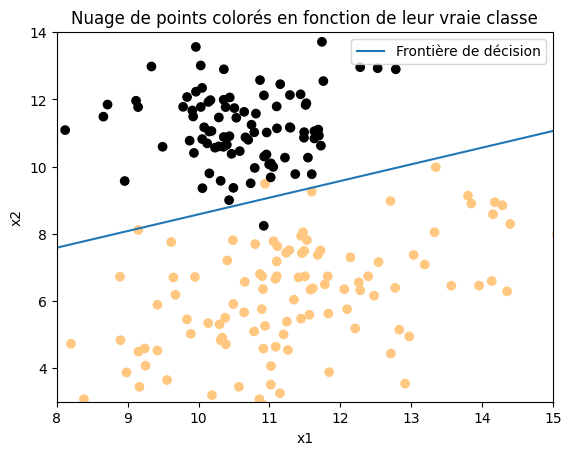

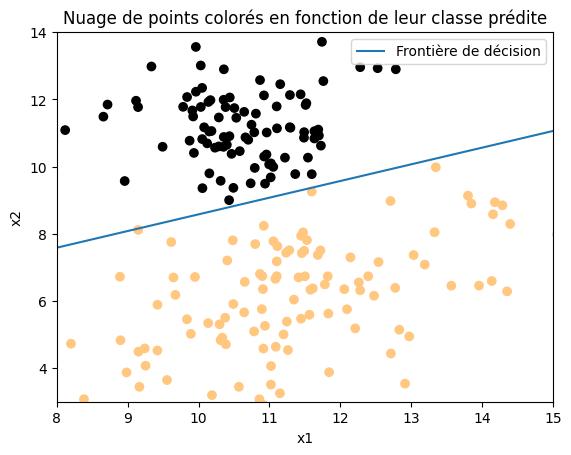

In [67]:
plot_log_reg_points_decision_border(cmap="true")
plot_log_reg_points_decision_border(cmap="pred")

On voit que **la frontière de décision est différente** de celle de l'analyse linéaire discriminante.  
La régression logistique manque tout juste de se tromper de classe pour le point de coordonnées (9.8, 7), très proche de la  frontière.  

## 1.2 Régression linéaire

Le modèle de régression linéaire multivariée est donné par :
$$
y_i = \beta_0 + x_i^\top \beta + \epsilon_i, \quad \forall i \in \{1, \ldots, n\},
$$
où $\epsilon_i $ est i.i.d. selon une distribution normale $ N(0, \sigma^2) $.  

L'estimateur du maximum de vraisemblance du vecteur des paramètres de la régression $\beta$ est donné par :
$$
\hat{\beta}_{EMV} = (X^\top X)^{-1} X^\top Y.
$$


**Dans notre cas, nous considérons $y_i$ comme une variable réelle ne prenant que les valeurs 0 ou 1.**

### a- Donner les valeurs numériques des paramètres appris

In [68]:
# Compute linear regression parameters
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Print parameters
for i, param in enumerate(beta_hat):
    print(f"beta_{i} = {param}")

beta_0 = 0.882499841711289
beta_1 = 0.08258172475673495
beta_2 = -0.14757517016760824


### b- Représenter graphiquement les données sous la forme d’un nuage de points dans $\mathbb{R}^2$ ainsi que la fonction définie pour x∈R2 par l’équation $P(Y=1|X=x)=1/2$

Afin d'adapter la régression linéaire à notre problème de classification, on adopte la règle suivante :
$$y_i = \begin{cases}
    0 & \text{si} \hspace{10px} \beta_0 + x_i^\top \beta \leq \frac{1}{2} \\
    1 & \text{si} \hspace{10px} \beta_0 + x_i^\top \beta > \frac{1}{2}
\end{cases}$$

Ainsi, la frontière de décision est située sur la droite représentée par l'équation
$$\beta_0 + x_i^T \beta = \frac{1}{2}
$$
$$\Leftrightarrow
x_1 = \frac{
    \frac{1}{2} - \beta_0 - x_2 \beta_2
}{
    \beta_1
} \hspace{10px} \text{sous réserve que $\beta_1 \ne 0$}
$$

In [69]:
# Calculate decision border
f_xx2 = (0.5 - beta_hat[0] - xx2 * beta_hat[2]) / beta_hat[1]

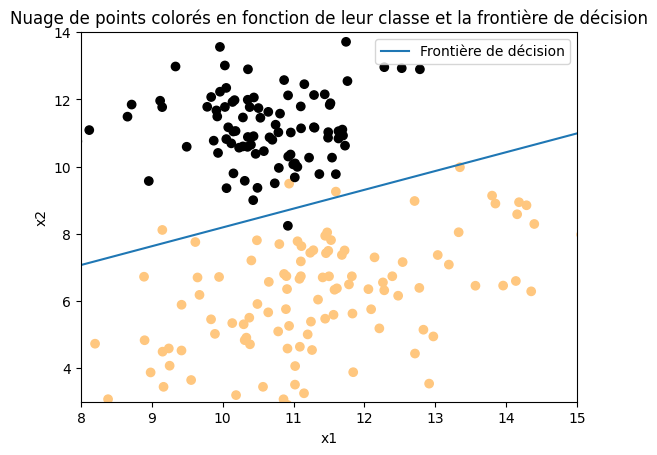

In [70]:
# Plot data points colored based on prediction
plt.scatter(
    dataset.loc[:, "x1"], dataset.loc[:, "x2"], c=dataset.loc[:, "y"], cmap="copper"
)
plt.plot(f_xx2, xx2, label="Frontière de décision")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title(
    "Nuage de points colorés en fonction de leur classe et la frontière de décision"
)
plt.legend()
plt.ylim([3, 14])
plt.xlim([8, 15])
plt.show()

## 4. Réseau de neurones
Implémenter un classifieur pour ce problème à l'aide de PyTorch (obligatoirement). Le classifieur doit être un réseau de neurones à 5 couches cachées. Chaque couche cachée $ j $ doit avoir $ 10 - j $ neurones. Ainsi, la première couche cachée doit avoir 9 neurones et la cinquième 5.


In [71]:
# Define neural network


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=9)
        self.fc2 = nn.Linear(9, 8)
        self.fc3 = nn.Linear(8, 7)
        self.fc4 = nn.Linear(7, 6)
        self.fc5 = nn.Linear(6, 5)
        self.fc6 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        return x

In [72]:
# Reshape y for tensorflow
y = np.array(y).reshape(-1, 1)

# Define X
X = dataset.loc[:, ["x1", "x2"]].to_numpy()

# Convert data to PyTorch tensors
X_tensor = torch.Tensor(X)
y_tensor = torch.Tensor(y)

In [73]:
# Create model
model = Classifier()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [74]:
# Train model
num_epochs = 1000
for epoch in range(num_epochs):
    # Make forward pass
    outputs = model.forward(X_tensor)
    loss = criterion.forward(outputs, y_tensor)

    # Make backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))

Epoch [100/1000], Loss: 0.0466
Epoch [200/1000], Loss: 0.0416
Epoch [300/1000], Loss: 0.0403
Epoch [400/1000], Loss: 0.0399
Epoch [500/1000], Loss: 0.0410
Epoch [600/1000], Loss: 0.0399
Epoch [700/1000], Loss: 0.0399
Epoch [800/1000], Loss: 0.0399
Epoch [900/1000], Loss: 0.0399
Epoch [1000/1000], Loss: 0.0399


### a- Donner les valeurs numériques des paramètres appris


In [75]:
# Display parameters
for name, param in model.named_parameters():
    print(name, param.data)

fc1.weight tensor([[ 0.7053, -0.6710],
        [ 0.9177,  0.4546],
        [ 0.5483,  0.8238],
        [ 0.6277,  0.5014],
        [-0.3913, -0.3083],
        [-0.1684,  0.0072],
        [-0.0638, -0.2440],
        [ 0.5138, -0.3951],
        [ 0.9267, -0.7620]])
fc1.bias tensor([ 0.3005,  0.4827, -0.7636, -0.8505, -0.7036, -0.6688, -0.4775,  1.0368,
         1.7740])
fc2.weight tensor([[ 0.2795,  0.6433,  0.4542,  0.3844, -0.1693, -0.2018, -0.1970,  0.4663,
          0.5306],
        [-0.2274, -0.1340,  0.1333, -0.1827,  0.2227, -0.1336,  0.1677,  0.1188,
         -0.2060],
        [ 0.0550, -0.2627, -0.0810, -0.2743,  0.2574,  0.2201, -0.1578, -0.3193,
          0.1262],
        [ 0.5593,  0.2879,  0.5320,  0.4923, -0.0514, -0.2005,  0.1468,  0.3966,
          0.2672],
        [-0.2217,  0.1593, -0.2047, -0.3840, -0.1335,  0.2755, -0.1045,  0.0614,
          0.1618],
        [-0.1916,  0.3440,  0.4253,  0.1918,  0.3123, -0.2991, -0.2193, -0.4475,
         -0.2235],
        [-0.1250, 

### b- Représenter graphiquement les données sous la forme d’un nuage de points dans $\mathbb{R}^2$ ainsi que la fonction définie pour x∈R2 par l’équation $P(Y=1|X=x)=1/2$

In [76]:
# Prepare meshgrid for displaying decision border
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xx.shape

(142, 95)

In [77]:
# Transform meshgrid into data points
datapoints_grid = np.c_[xx.ravel(), yy.ravel()]

# Transform datapoints into torch tensor
datapoints_grid = torch.Tensor(datapoints_grid)
datapoints_grid.shape

torch.Size([13490, 2])

In [78]:
# Predict grid to plot decision border
y_pred_grid = model.forward(datapoints_grid).detach().numpy()

# Reshape predictions into grid shape
y_pred_grid = y_pred_grid.reshape(xx.shape)
y_pred_grid.shape

(142, 95)

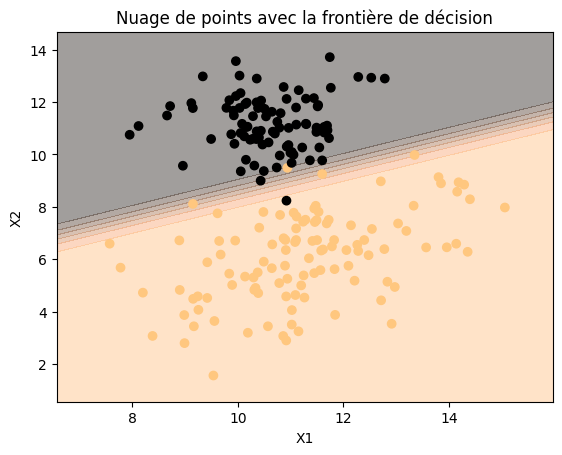

In [79]:
# Plot datapoints and decision border
plt.contourf(xx, yy, y_pred_grid, alpha=0.4, cmap="copper")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="copper")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Nuage de points avec la frontière de décision")
plt.show()

## 5. Application

Les données des fichiers testA, testB et testC sont respectivement tirées de la même distribution que les données des fichiers trainA, trainB et trainC. Tester les différents modèles appris à partir des données d’apprentissage correspondantes sur ces données de test.


### a- Calculer pour chaque modèle l’erreur de classification (c’est-à-dire la fraction des données mal classées) sur les données d’apprentissage et calculer-la également sur les données de test.

In [80]:
class LogisticRegression:
    def __init__(self) -> None:
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Add bias to X
        X = np.c_[np.ones((X.shape[0], 1)), X]

        # Init parameters
        beta = np.zeros(X.shape[1])

        # Optimize cost function
        beta_hat = minimize(fun=log_reg_cost_function, x0=beta, args=(X, y))

        # Retrieve array of values
        self.beta_hat = beta_hat.x

        return self.beta_hat

    def predict(self, X: np.ndarray):
        """Make prediction for logistic regression with two dimensional data

        Args:
            X (np.ndarray): Dataset + column of ones for bias

        Returns:
            tuple: predictions and predicted proba
        """
        # Retrieve parameters
        params = self.beta_hat

        # Add bias to X
        X = np.c_[np.ones((X.shape[0], 1)), X]

        linear_reg_part = X @ params
        y_pred_proba = sigmoid(linear_reg_part)
        y_pred = [proba > 0.5 for proba in y_pred_proba]

        return y_pred, y_pred_proba

In [81]:
class LinearRegression:
    def __init__(self) -> None:
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Add bias to X
        X = np.c_[np.ones((X.shape[0], 1)), X]

        # Compute linear regression parameters
        self.beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        return self.beta_hat

    def predict(self, X: np.ndarray):
        """Make prediction for linear regression with two dimensional data

        Args:
            X (np.ndarray): Dataset + column of ones for bias
            params (np.ndarray): Array of parameters (beta0, beta1, beta2)

        Returns:
            tuple: predictions and predicted proba
        """
        # Retrieve parameters
        params = self.beta_hat

        # Add bias to X
        X = np.c_[np.ones((X.shape[0], 1)), X]

        y_pred_proba = X @ params
        y_pred = [proba > 0.5 for proba in y_pred_proba]

        return y_pred, y_pred_proba

In [82]:
class LinearDiscriminantAnalysis:
    def __init__(self) -> None:
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Adapt data to MLE calculation function
        df = pd.DataFrame({"x1": X[:, 0], "x2": X[:, 1], "y": y})

        # Make calculus
        self.pi = calc_pi_mle(df)
        self.mu0, self.mu1 = calc_mu_mle(df)
        self.sigma = calc_sigma_mle(df, self.mu0, self.mu1)
        self.params = (self.pi, self.mu0, self.mu1, self.sigma)

        return self.pi, self.mu0, self.mu1, self.sigma

    def predict(self, X: np.ndarray) -> tuple:
        """Make prediction for linear discriminant analysis

        Args:
            X (np.ndarray): Two dimensional dataset

        Returns:
            tuple: predictions and predicted proba
        """
        # Retrieve parameters
        pi, mu0, mu1, Sigma = self.params
        Sigma_inv = np.linalg.inv(Sigma)

        # Calculate proba

        # Iterate over row i.e. data points
        exponential_part = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            exponential_part[i] = 0.5 * (
                (X[i] - mu0) @ Sigma_inv @ (X[i] - mu0).T
                - (X[i] - mu1) @ Sigma_inv @ (X[i] - mu1).T
            )

        denominateur = 1 + ((1 - pi) / pi) * np.exp(exponential_part)

        y_pred_proba = 1 / denominateur

        y_pred = [
            proba < 0.5 for proba in y_pred_proba
        ]  # I don't know why I must take proba < 0.5 and not > 0.5

        return y_pred, y_pred_proba

In [83]:
# Create dictionnary to store datasets summary
results = {}

# Iterate over datasets
for dataset_index in ["A", "B", "C"]:
    # Define train test split
    X_train, X_test = (
        train[dataset_index].loc[:, ["x1", "x2"]].to_numpy(),
        test[dataset_index].loc[:, ["x1", "x2"]].to_numpy(),
    )
    y_train, y_test = (
        train[dataset_index].loc[:, "y"].to_numpy(),
        test[dataset_index].loc[:, "y"].to_numpy(),
    )

    # Init results storage
    results[dataset_index] = []

    # Iterate over models
    for model in [
        LinearDiscriminantAnalysis(),
        LinearRegression(),
        LogisticRegression(),
    ]:
        model.fit(X_train, y_train)
        y_train_pred, _ = model.predict(X_train)
        y_test_pred, _ = model.predict(X_test)
        train_accuracy = sum(
            1 for true, pred in zip(y_train_pred, y_train) if true == pred
        ) / len(y_train)
        test_accuracy = sum(
            1 for true, pred in zip(y_test, y_test_pred) if true == pred
        ) / len(y_test)
        # Append result
        results[dataset_index].append(
            {
                "Model": type(model).__name__,
                "Train Accuracy": train_accuracy,
                "Test Accuracy": test_accuracy,
            }
        )

    results[dataset_index] = pd.DataFrame(results[dataset_index])

C:\Users\jules\AppData\Local\Temp\ipykernel_11768\3643534343.py:9: RuntimeWarning: divide by zero encountered in log
  error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
C:\Users\jules\AppData\Local\Temp\ipykernel_11768\3643534343.py:9: RuntimeWarning: invalid value encountered in multiply
  error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
C:\Users\jules\AppData\Local\Temp\ipykernel_11768\3643534343.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\jules\AppData\Local\Temp\ipykernel_11768\3643534343.py:9: RuntimeWarning: divide by zero encountered in log
  error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
C:\Users\jules\AppData\Local\Temp\ipykernel_11768\3643534343.py:9: RuntimeWarning: invalid value encountered in multiply
  error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
C:\Users\jules\AppData\Local\Temp\ipykernel_11768\3643534343.py:3: RuntimeWarning: overflow encount

**Dataset A**

In [84]:
results["A"]

,Model,Train Accuracy,Test Accuracy
0,LinearDiscriminantAnalysis,1.0,0.99
1,LinearRegression,1.0,0.99
2,LogisticRegression,1.0,0.98


**Dataset B**

In [85]:
results["B"]

,Model,Train Accuracy,Test Accuracy
0,LinearDiscriminantAnalysis,0.975,0.950
1,LinearRegression,0.980,0.955
2,LogisticRegression,0.990,0.965


**Dataset C**

In [86]:
results["C"]

,Model,Train Accuracy,Test Accuracy
0,LinearDiscriminantAnalysis,0.973333,0.966667
1,LinearRegression,0.973333,0.960000
2,LogisticRegression,0.970000,0.953333


### b- Comparer les performances des différentes méthodes sur les trois jeux de données. L’erreur de classification est-elle plus grande, plus petite ou similaire sur les données d’entraînement et de test ? Pourquoi ? Quelles méthodes donnent des résultats très similaires/différents ? Quelles méthodes donnent les meilleurs résultats sur les différents jeux de données ? Donner une interprétation.

In [87]:
# TODO

# 2- Modèle de mélange Gaussien et algorithme EM
